# Figures for SDO/HMI Paper

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.linear_model import LinearRegression
import tamar.tools.utilities as utils
import tamar.tools.plotting_funcs as plot
from tamar.tools.settings import CsvDir, ImgDir, PlotDir, Config
from scipy.signal import lombscargle
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

from astropy.io import fits
import NEIDcode
import glob
from tqdm import tqdm

import corner

In [2]:
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

In [3]:
# quality threshold plus one
qual_thresh = 3

# Figure One: SDO/HMI Images (sdo_hmi.png)

In [12]:
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2021-6-30T12:00:00.00'  # start date of query
end_date = '2021-6-30T12:01:00.00'
physobs_list = [a.Physobs.los_velocity, a.Physobs.los_magnetic_field, a.Physobs.intensity]

result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.hmi, physobs_list[0] | physobs_list[1] | physobs_list[2], cadence)
# download results
file_download = Fido.fetch(result)
# convert to map sequence
map_seq = sunpy.map.Map(sorted(file_download))

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

hmi_m_45s_2021_06_30_12_01_30_tai_magnetogram.fits:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

hmi_ic_45s_2021_06_30_12_01_30_tai_continuum.fits:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

hmi_v_45s_2021_06_30_12_01_30_tai_dopplergram.fits:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

In [13]:
import tamar.tools.solar_funcs as sfuncs
import tamar.tools.lbc_funcs as lbfuncs
import tamar.tools.coord_funcs as ctfuncs

# remove unusable file types
good_files = []
for file in file_download:
    name, extension = os.path.splitext(file)
    if extension == '.fits':
        good_files.append(file)

if len(good_files) != 3:
    print('Not enough files.')
    pass
else:
    # convert to map sequence
    map_seq = sunpy.map.Map(sorted(good_files))

    # check for missing data types
    missing_map = False
    # split into data types
    for j, map_obj in enumerate(map_seq):
        if map_obj.meta['content'] == 'DOPPLERGRAM':
            vmap = map_obj
        elif map_obj.meta['content'] == 'MAGNETOGRAM':
            mmap = map_obj
        elif map_obj.meta['content'] == 'CONTINUUM INTENSITY':
            imap = map_obj
        else:
            missing_map = True

    if missing_map:
        pass

    else:
        # coordinate transformation for maps
        x, y, pdim, r, d, mu = ctfuncs.coordinates(vmap)
        wij, nij, rij = ctfuncs.vel_coords(x, y, pdim, r, vmap)

        # remove bad mu values
        vmap, mmap, imap = ctfuncs.fix_mu(mu, [vmap, mmap, imap])

        # calculate relative positions
        deltaw, deltan, deltar, dij = sfuncs.rel_positions(wij, nij, rij, vmap)

        # calculate spacecraft velocity
        vsc = sfuncs.spacecraft_vel(deltaw, deltan, deltar, dij, vmap)

        # optimized solar rotation parameters
        a1 = 14.713
        a2 = -2.396
        a3 = -1.787
        a_parameters = [a1, a2, a3]

        # calculation of solar rotation velocity
        # vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)
        vrot = sfuncs.solar_rot_vel(wij, nij, rij, deltaw, deltan, deltar, dij, vmap, a_parameters)

        # calculate corrected velocity
        corrected_vel = vmap.data - np.real(vsc) - np.real(vrot)

        # corrected velocity maps
        map_vel_cor = sfuncs.corrected_map(corrected_vel, vmap, map_type='Corrected-Dopplergram',
                                           frame=frames.HeliographicCarrington)

        # limb brightening
        Lij = lbfuncs.limb_polynomial(imap)

        # calculate corrected data
        Iflat = imap.data / Lij

        # corrected intensity maps
        map_int_cor = sfuncs.corrected_map(Iflat, imap, map_type='Corrected-Intensitygram',
                                           frame=frames.HeliographicCarrington)

        # magnetic noise level
        B_noise = 8

        # calculate unsigned field strength
        Bobs, Br = sfuncs.mag_field(mu, mmap, B_noise)

        # corrected observed magnetic data map
        map_mag_obs = sfuncs.corrected_map(Bobs, mmap, map_type='Corrected-Magnetogram',
                                           frame=frames.HeliographicCarrington)

        # radial magnetic data map
        map_mag_cor = sfuncs.corrected_map(Br, mmap, map_type='Corrected-Magnetogram',
                                           frame=frames.HeliographicCarrington)
        # magnetic threshold value (G) from Yeo et. al. 2013
        Br_cutoff = 24
        # mu cutoff value
        mu_cutoff = 0.3

        # calculate magnetic threshold
        active, quiet = sfuncs.mag_thresh(mu, mmap, Br_cutoff=Br_cutoff, mu_cutoff=mu_cutoff)

        # calculate intensity threshold
        fac_inds, spot_inds = sfuncs.int_thresh(map_int_cor, active, quiet)

        # create threshold array
        thresh_arr = sfuncs.thresh_map(fac_inds, spot_inds)

        # full threshold maps
        map_full_thresh = sfuncs.corrected_map(thresh_arr, mmap, map_type='Threshold',
                                               frame=frames.HeliographicCarrington)

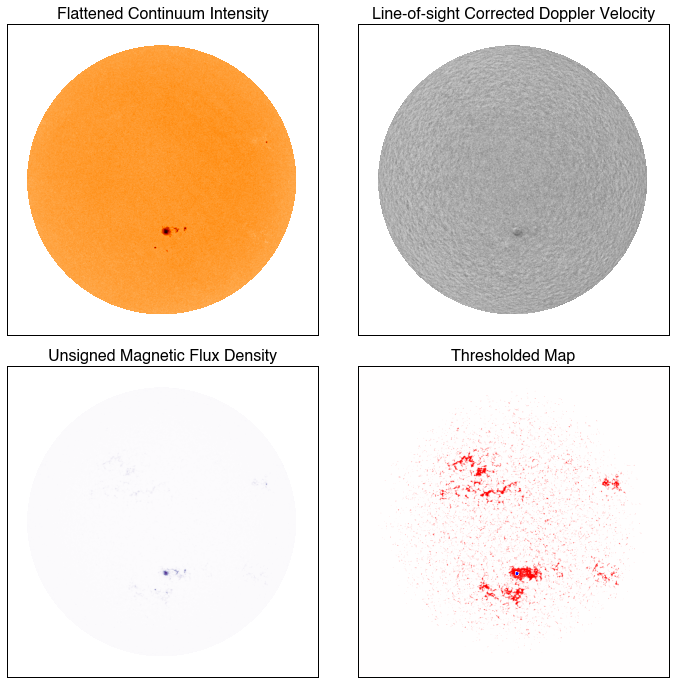

In [14]:
# make cute plots
fig, axs = plt.subplots(2, 2, sharey='row', sharex='col', figsize=[12, 12], gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# intensity map
int_data = map_int_cor.data
int_data = np.where(int_data == 0, np.nan, int_data)
axs[0, 0].imshow(int_data, cmap=plt.get_cmap('hinodesotintensity'))
axs[0, 0].set_title("Flattened Continuum Intensity")
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('hinodesotintensity')), ax=axs[0, 0])

# magnetic field map
mag_data = np.abs(map_mag_cor.data)
# mag_data = np.where(mag_data == 0, np.nan, mag_data)
axs[1, 0].imshow(mag_data, cmap=plt.get_cmap('Purples'))
axs[1, 0].set_title("Unsigned Magnetic Flux Density")
# fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Purples')), ax=axs[1, 0])

# Doppler map
good_mu = np.logical_and(mu > 0.3, mu != np.nan)
vel_data = np.full(map_vel_cor.data.shape, np.nan)
vel_data[good_mu] = map_vel_cor.data[good_mu]
axs[0, 1].imshow(vel_data, cmap=plt.get_cmap('Greys'))
axs[0, 1].set_title("Line-of-sight Corrected Doppler Velocity")

# threshold image
fac = fac_inds.astype(int)
spot = 1 - spot_inds.astype(int)
thresh = spot + fac
axs[1, 1].imshow(thresh, cmap=plt.get_cmap('bwr'))
axs[1, 1].set_title("Thresholded Map")


# tick marks
for i in range(0, 2):
    for j in range(0, 2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])



# Figure 2: Comparison w Milbourne Dataset (milbourne_comp.png)

In [14]:
# csv file with rv components
csv_file = os.path.join(CsvDir.MILBOURNE, 'full_calcs.csv')

# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get column names
components = component_df.columns.values

# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_model = component_df.rv_model.values

# get reference lists
v_phot_ref = component_df.v_phot_ref.values
v_conv_ref = component_df.v_conv_ref.values
rv_model_ref = component_df.rv_model_ref2.values
rv_sun = component_df.rv_sun.values

# get magnetic observables
f = component_df.f.values
Bobs = component_df.Bobs.values
f_bright = component_df.f_bright.values
f_spot = component_df.f_spot.values

# get reference observable
f_ref = component_df.f_ref.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
all_days = range(0, len(dates))

# get range based on good indices
days_range = range(0, len(Bobs))

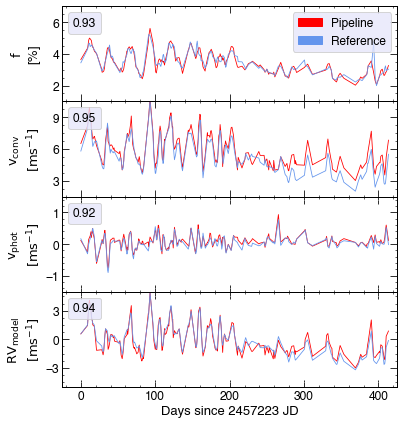

In [15]:
# comparison of velocities
x = date_jd[:217] - date_jd[0]
my_list = [f[:217], v_conv[:217], v_phot[:217], rv_model[:217] - np.mean(rv_model[:217])]
ref_list = [f_ref[:217], v_conv_ref[:217], v_phot_ref[:217], rv_model_ref[:217] - np.mean(rv_model_ref[:217])]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm f$' '\n' r'$\rm$[%]',
               r'$\rm v_{\rm conv}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm v_{\rm phot}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm model}$' '\n' r'$\rm[m s^{-1}]$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(my_list), 1, sharex='all', figsize=[6, 1.75 * len(my_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(1, 7), yticks=np.arange(2, 6.2, step=2))
axs[1].set(ylim=(1.5, 10.5), yticks=np.arange(3.0, 10.2, step=3))
axs[2].set(ylim=(- 1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[3].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[3].set(xlim=(-25, 425), xticks=np.arange(0, 402, step=100))

# calculate correlation coefficient
corr_one = stats.spearmanr(my_list[0], ref_list[0])
corr_two = stats.spearmanr(my_list[1], ref_list[1])
corr_three = stats.spearmanr(my_list[2], ref_list[2])
corr_four = stats.spearmanr(my_list[3], ref_list[3])
corr_list = [corr_one, corr_two, corr_three, corr_four]

# plot data
ax1label = axs[0].plot(x, my_list[0], color='red', linewidth=0.8, label=np.round(corr_list[0][0], 2))
ax1nolabel = axs[0].plot(x, ref_list[0], color='cornflowerblue', linewidth=0.8)
for i in range(1, len(axs)):
    axs[i].plot(x, my_list[i], color='red', linewidth=0.8, label=np.round(corr_list[i][0], 2))
    axs[i].plot(x, ref_list[i], color='cornflowerblue', linewidth=0.8)

# legend
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


for i in range(1, 4):
    leg = axs[i].legend(handlelength=0, handletextpad=0, loc='upper left')
    for item in leg.legendHandles:
        item.set_visible(False)

# axes one legend
red_patch = mpatches.Patch(color='red', label='Pipeline')
blue_patch = mpatches.Patch(color='cornflowerblue', label='Reference')

leg1 = axs[0].legend(handles=[red_patch, blue_patch], loc='upper right')

leg2 = axs[0].legend(handlelength=0, handletextpad=0, loc='upper left')

axs[0].add_artist(leg1)

fig.align_ylabels(axs)

plt.show()

# Figure 3: Comparison between SDO/HMI and NEID Data (velocities.png)

# Read in Data

# Read in CSV file

In [35]:

# csv file with rv components
csv_file = os.path.join(CsvDir.NEID_CALC, 'paper_rvs.csv')

# create pandas dataframe
component_df = pd.read_csv(csv_file)

# get dates list
date_jd = component_df.date_jd.values
inds = np.argsort(date_jd)

rv_sun = component_df.rv_sun.values[inds]
rv_error = component_df.rv_error.values[inds]

non_nan = np.logical_not(np.isnan(rv_sun))

rv_med = np.nanmedian(np.abs(rv_sun))

good_sun = np.logical_and(np.abs(rv_sun) > rv_med - 2, np.abs(rv_sun) < rv_med + 2)
good_error = np.logical_and(np.abs(rv_error) < .4, np.abs(rv_error) < .4)
good = np.logical_and(good_sun, good_error)

good_rvs = np.logical_and(good, non_nan)

# get velocities lists
v_phot = component_df.v_phot.values[inds][good_rvs]
v_conv = component_df.v_conv.values[inds][good_rvs]
rv_model = component_df.rv_model.values[inds][good_rvs]
rv_sun = rv_sun[good_rvs]
rv_error = rv_error[good_rvs]
v_quiet = component_df.v_quiet.values[inds][good_rvs]
v_disc = component_df.v_disc.values[inds][good_rvs]
vconv_large = component_df.vconv_large.values[inds][good_rvs]
vconv_small = component_df.vconv_small.values[inds][good_rvs]
vphot_bright = component_df.vphot_bright.values[inds][good_rvs]
vphot_spot = component_df.vphot_spot.values[inds][good_rvs]

# get magnetic observables
f = component_df.f.values[inds][good_rvs]
Bobs = component_df.Bobs.values[inds][good_rvs]
f_bright = component_df.f_bright.values[inds][good_rvs]
f_spot = component_df.f_spot.values[inds][good_rvs]
f_plage = component_df.f_plage.values[inds][good_rvs]
f_network = component_df.f_network.values[inds][good_rvs]
ar_flux = component_df.ar_flux.values[inds][good_rvs]
quiet_flux = component_df.quiet_flux.values[inds][good_rvs]

# dates
date_jd = date_jd[inds][good_rvs]
dates = component_df.date_obs.values[inds][good_rvs]
plot_dates = date_jd - date_jd[0]

# Good Weather Dates

In [36]:
bad_days_csv = os.path.join(CsvDir.NEID_DATA, 'pyr_quality_by_day.csv')

save_fig = None

# create pandas dataframe
quality_df = pd.read_csv(bad_days_csv)

# get dates
qual_dates = quality_df.DATE.values
quality = quality_df.QUAL.values

# make dates compatible
times = [str(d)[0:4] + "-" + str(d)[4:6] + '-' + str(d)[6:8] + 'T12:00:00' for d in qual_dates]
dt = [utils.get_dates(d) for d in times]
date_str = [d[0] for d in dt]
date_obj = [d[1] for d in dt]
jd = [d[2].value for d in dt]

good_days = np.where(quality < qual_thresh, jd, None)
good_days = list(filter(None, list(good_days)))
neid_inds = np.isin(date_jd, good_days)

g_v_phot = v_phot[neid_inds]
g_v_conv = v_conv[neid_inds]
g_rv_sun = rv_sun[neid_inds]
g_rv_model = rv_model[neid_inds]
g_f = f[neid_inds]
g_f_spot = f_spot[neid_inds]
g_f_bright = f_bright[neid_inds]
g_Bobs= Bobs[neid_inds]
g_dates = dates[neid_inds]
g_date_jd = date_jd[neid_inds]
g_days_range = range(0, len(dates))
g_plot_dates = g_date_jd - g_date_jd[0]

g_vconv_large = vconv_large[neid_inds]
g_vconv_small = vconv_small[neid_inds]
g_vphot_bright = vphot_bright[neid_inds]
g_vphot_spot = vphot_spot[neid_inds]

g_f_plage = f_plage[neid_inds]
g_f_network = f_network[neid_inds]
g_ar_flux = ar_flux[neid_inds]

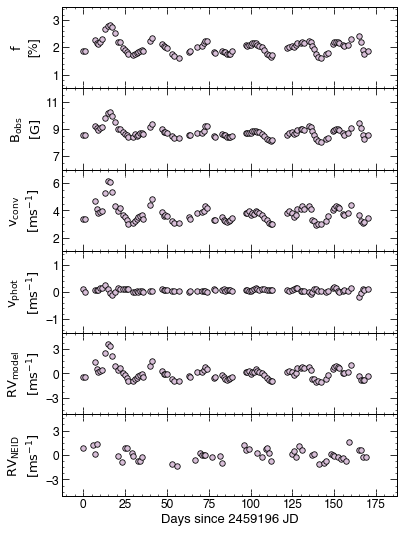

In [18]:
x = [plot_dates, g_plot_dates]
y_list = [f, Bobs, v_conv, v_phot, rv_model - np.median(rv_model), g_rv_sun - np.median(g_rv_sun)]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm f$' '\n' r'$\rm$[%]', r'$\rm B_{\rm obs}$' '\n' r'$\rm [G]$',
               r'$\rm v_{\rm conv}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm v_{\rm phot}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm model}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm NEID}$' '\n' r'$\rm[m s^{-1}]$']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[6, 1.5 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(0.5, 3.5), yticks=np.arange(1.0, 3.2, step=1))
axs[1].set(ylim=(6.0, 12.0), yticks=np.arange(7, 11.2, step=2))
axs[2].set(ylim=(1, 7.0), yticks=np.arange(2, 6.2, step=2))
axs[3].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[4].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[5].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[5].set(xlim=(-12.5, 187.5), xticks=np.arange(0, 180, step=25))

# plot data
for i in range(0, len(axs)):
    if i ==5:
        x_plot = x[1]
    else:
        x_plot = x[0]
    axs[i].scatter(x_plot, y_list[i], color='thistle', s=30, edgecolors='k', linewidths=0.8, label='rms: ' + str(np.round(np.std(y_list[i]), 3)))

# align y axis labels
fig.align_ylabels(axs)


# Figure 4: vconv_area.png
- periodogram of area based convective velocities

findfont: Font family ['Helvetica Neue LT Pro'] not found. Falling back to DejaVu Sans.


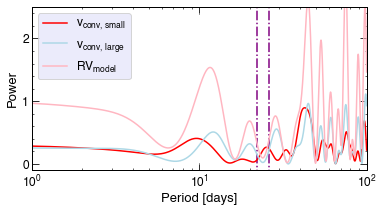

In [19]:

# periodogram of convective velocity components
jd = plot_dates

# rough time sampling
freqs = np.linspace(1, 1/jd[-1], 2500)

# rv
drv_rv = (rv_model - np.mean(rv_model))
ls_rv = lombscargle(jd, drv_rv, freqs)

# conv
drv_conv = (v_conv - np.mean(v_conv))
ls_conv = lombscargle(jd, drv_conv, freqs)

# conv large
drv_large = (vconv_large - np.mean(vconv_large))
ls_large = lombscargle(jd, drv_large, freqs)

# conv small
drv_small = (vconv_small - np.mean(vconv_small))
ls_small = lombscargle(jd, drv_small, freqs)

# plot
plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
days = np.linspace(jd[0], jd[-1], 2500)
fig = plt.figure(figsize=[6, 3])

plt.plot(days, ls_small, 'red', label=r'$\rm v_{\rm conv, \, small}$')
plt.plot(days, ls_large, 'lightblue', label=r'$\rm v_{\rm conv, \, large}$')
plt.plot(days, ls_rv, 'lightpink', label=r'$\rm RV_{\rm model}$')
# plt.vlines([days[287], days[385]], -1, 5, colors='purple', linestyles='dashdot')
use = np.logical_and(22 <= days, days <= 26)
use1 = np.where(days == days[use][0])
use2 =np.where(days == days[use][-1])
plt.vlines([days[use1], days[use2]], -1, 5, colors='purple', linestyles='dashdot')

plt.xlim(10e-1, 10e1)
plt.ylim(-0.1,2.5)
plt.yticks([0, 1, 2])
plt.xscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.xlim(10e-1, 10e1)

plt.legend()

# FIGURE 5: BEST NEID DAYS (Bobs_rv_fit.png)

In [20]:

# # csv file with rv components
# csv_file = os.path.join(CsvDir.NEID_CALC, 'rvs_from_fits.csv')
#
# # create pandas dataframe
# component_df = pd.read_csv(csv_file)
#
# # get dates list
# date_jd = component_df.date_jd.values
# inds = np.argsort(date_jd)
#
# rv_sun = component_df.rv_sun.values[inds]
# rv_error = component_df.rv_error.values[inds]
#
# non_nan = np.logical_not(np.isnan(rv_sun))
#
# rv_med = np.nanmedian(np.abs(rv_sun))
#
# good_sun = np.logical_and(np.abs(rv_sun) > rv_med - 2, np.abs(rv_sun) < rv_med + 2)
# good_error = np.logical_and(np.abs(rv_error) < .4, np.abs(rv_error) < .4)
# good = np.logical_and(good_sun, good_error)
#
# good_rvs = np.logical_and(good, non_nan)
#
# # get velocities lists
# v_phot = component_df.v_phot.values[inds][good_rvs]
# v_conv = component_df.v_conv.values[inds][good_rvs]
# rv_model = component_df.rv_model.values[inds][good_rvs]
# rv_sun = rv_sun[good_rvs]
# rv_error = rv_error[good_rvs]
# v_quiet = component_df.v_quiet.values[inds][good_rvs]
# v_disc = component_df.v_disc.values[inds][good_rvs]
# vconv_large = component_df.vconv_large.values[inds][good_rvs]
# vconv_small = component_df.vconv_small.values[inds][good_rvs]
# vphot_bright = component_df.vphot_bright.values[inds][good_rvs]
# vphot_spot = component_df.vphot_spot.values[inds][good_rvs]
#
# # get magnetic observables
# f = component_df.f.values[inds][good_rvs]
# Bobs = component_df.Bobs.values[inds][good_rvs]
# f_bright = component_df.f_bright.values[inds][good_rvs]
# f_spot = component_df.f_spot.values[inds][good_rvs]
# f_plage = component_df.f_plage.values[inds][good_rvs]
# f_network = component_df.f_network.values[inds][good_rvs]
# ar_flux = component_df.ar_flux.values[inds][good_rvs]
# quiet_flux = component_df.quiet_flux.values[inds][good_rvs]
#
# # dates
# date_jd = date_jd[inds][good_rvs]
# dates = component_df.date_obs.values[inds][good_rvs]
# plot_dates = date_jd - date_jd[0]

In [21]:
# bad_days_csv = os.path.join(CsvDir.NEID_DATA, 'pyr_quality_by_day.csv')
#
# save_fig = None
#
# # create pandas dataframe
# quality_df = pd.read_csv(bad_days_csv)
#
# # get dates
# qual_dates = quality_df.DATE.values
# quality = quality_df.QUAL.values
#
# # make dates compatible
# times = [str(d)[0:4] + "-" + str(d)[4:6] + '-' + str(d)[6:8] + 'T12:00:00' for d in qual_dates]
# dt = [utils.get_dates(d) for d in times]
# date_str = [d[0] for d in dt]
# date_obj = [d[1] for d in dt]
# jd = [d[2].value for d in dt]
#
# good_days = np.where(quality < 2, jd, None)
# good_days = list(filter(None, list(good_days)))
# neid_inds = np.isin(date_jd, good_days)
#
# g_v_phot = v_phot[neid_inds]
# g_v_conv = v_conv[neid_inds]
# g_rv_sun = rv_sun[neid_inds]
# g_rv_model = rv_model[neid_inds]
# g_f = f[neid_inds]
# g_f_spot = f_spot[neid_inds]
# g_f_bright = f_bright[neid_inds]
# g_Bobs= Bobs[neid_inds]
# g_dates = dates[neid_inds]
# g_date_jd = date_jd[neid_inds]
# g_days_range = range(0, len(dates))
# g_plot_dates = g_date_jd - g_date_jd[0]

In [22]:
# removal of unsigned flux
X = g_Bobs.reshape(-1, 1)
Y = g_rv_sun
reg = LinearRegression(positive=True).fit(X, Y)
m, b = reg.coef_, reg.intercept_

fit_line = m*g_Bobs + b
rv_Bobs = g_rv_sun - fit_line

[Text(0.5, 0, 'Days since 2459196 JD')]

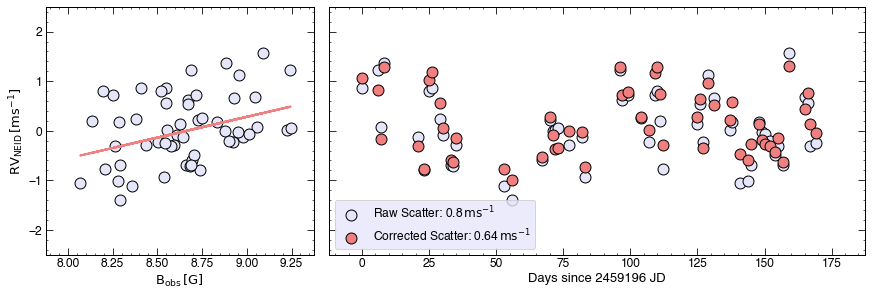

In [37]:

fig = plt.figure(constrained_layout=True, figsize=(12, 4))
widths = [4, 8]
heights = [4]
gs = fig.add_gridspec(1, 2, width_ratios=widths, height_ratios=heights)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

ax1.scatter(g_Bobs, g_rv_sun - np.median(g_rv_sun), color='lavender', edgecolors='k', linewidths=1.0, s=120)
ax1.plot(g_Bobs, fit_line - np.median(fit_line), color='lightcoral', linewidth=2.0)

ax2.scatter(g_plot_dates, g_rv_sun - np.median(g_rv_sun), color='lavender', edgecolors='k', linewidths=1.0, s=120, label='Raw Scatter: ' + str(np.round(np.std(rv_sun), 2)) + r'$ \/\rm m s^{-1}$')
ax2.scatter(g_plot_dates, rv_Bobs - np.median(rv_Bobs), color='lightcoral', edgecolors='k', linewidths=1.0, s=120, label='Corrected Scatter: ' + str(np.round(np.std(rv_Bobs), 2)) + r'$ \/\rm m s^{-1}$')
ax2.legend(loc='lower left')

ax1.set(xlim=(7.875, 9.375), yticks=np.arange(8, 9.252, step=.25))
ax1.set(ylim=(- 2.5, 2.5), yticks=np.arange(-2, 2.23, step=1))
ax2.set(xlim=(-12.5, 187.5), xticks=np.arange(0, 180, step=25))
# ax2.set(xlim=(- 5, 85), xticks=np.arange(-0, 82, step=10))

plt.setp(ax2.get_yticklabels(), visible=False)

ax1.set(xlabel=r'$\rm B_{\rm obs}\/\rm [G]$', ylabel=r'$\rm RV_{\rm NEID}\/\rm [m s^{-1}]$')
ax2.set(xlabel='Days since ' + str(int(date_jd[0])) + ' JD')

# Figure 6: Comparison of observables (magnetic.png)

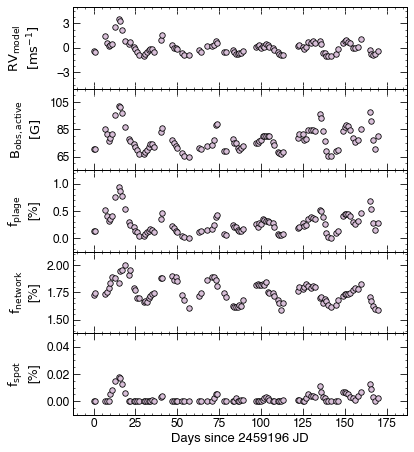

In [24]:

x = plot_dates
y_list = [rv_model - np.median(rv_model), ar_flux, f_plage, f_network, f_spot]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm RV_{\rm model}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm B_{\rm obs, active}$' '\n' r'$\rm [G]$',
               r'$\rm f_{\rm plage}$' '\n' r'$\rm$[%]',
               r'$\rm f_{\rm network}$' '\n' r'$\rm$[%]',
               r'$\rm f_{\rm spot}$' '\n' r'$\rm$[%]']


plot_style = os.path.join(PlotDir.MPL, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
# plt.rcParams['axes.unicode_minus'] = True
plt.style.use(plot_style)

# set up figure
fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[6, 1.5 * len(y_list)],  gridspec_kw={'hspace': 0})

# set up axes labels
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
axs[i].set(xlabel=xlabel)
axs[0].set(ylim=(- 5.0, 5.0), yticks=np.arange(-3, 3.2, step=3))
axs[1].set(ylim=(55, 115), yticks=np.arange(65, 105.2, step=20))
axs[2].set(ylim=(- 0.25, 1.25), yticks=np.arange(0, 1.2, step=0.5))
axs[3].set(ylim=(1.375, 2.125), yticks=np.arange(1.5, 2.125, step=0.25))
axs[4].set(ylim=(- .01, .05), yticks=np.arange(.0, .052, step=.02))
axs[4].set(xlim=(-12.5, 187.5), xticks=np.arange(0, 180, step=25))

# plot data
for i in range(0, len(axs)):
    axs[i].scatter(x, y_list[i], color='thistle', s=30, edgecolors='k', linewidths=0.8)


# align y axis labels
fig.align_ylabels(axs)

# FIGURE 7: Line Mask Comparisons (lines_correlation.png)

In [25]:
# correlation plot with unsigned flux and NEID RVs

# Wise et al. (2018) lines
# get Wise lines weighted orders
wise = os.path.join(CsvDir.CCFS, 'wise_lines.csv')
df = pd.read_pickle(wise)
wise_dates = df.dates.values
ccf_list = df.ccf.values
rv_model = df.rv_model.values
rv_error = df.rv_error.values
wise_rv = df.rv_sun.values
gaussian = df.gaussian.values
wise_gauss = df.rv_gauss.values
wise_Bobs = df.Bobs.values
wise_jd = df.jd_dates.values

# find bad CCFs -- need to figure out why this is...
bad_ccfs = np.array([np.isnan(ccf[0]) for ccf in ccf_list])
ccf_list = ccf_list[~bad_ccfs]
rv_model = rv_model[~bad_ccfs]
rv_error = rv_error[~bad_ccfs]
wise_rv = wise_rv[~bad_ccfs]
gaussian = gaussian[~bad_ccfs]
wise_gauss = wise_gauss[~bad_ccfs]
wise_Bobs = wise_Bobs[~bad_ccfs]
wise_dates = wise_dates[~bad_ccfs]
wise_jd = wise_jd[~bad_ccfs]

# get good weather dates
wise_inds = np.isin(wise_jd, good_days)

rv_model = rv_model[wise_inds]
rv_error = rv_error[wise_inds]
wise_rv = wise_rv[wise_inds]
gaussian = gaussian[wise_inds]
wise_gauss = wise_gauss[wise_inds]
wise_Bobs = wise_Bobs[wise_inds]
wise_dates = wise_dates[wise_inds]
wise_jd = wise_jd[wise_inds]


# Fe I lines (NIST)
# get Fe I weighted orders
FeI = os.path.join(CsvDir.CCFS, 'FeI_lines.csv')
df = pd.read_pickle(FeI)
fe_dates = df.dates.values
ccf_list = df.ccf.values
rv_model = df.rv_model.values
rv_error = df.rv_error.values
fe_rv = df.rv_sun.values
gaussian = df.gaussian.values
fe_gauss = df.rv_gauss.values
fe_Bobs = df.Bobs.values
fe_jd = df.jd_dates.values

# find bad CCFs -- need to figure out why this is...
bad_ccfs = np.array([np.isnan(ccf[0]) for ccf in ccf_list])
ccf_list = ccf_list[~bad_ccfs]
rv_model = rv_model[~bad_ccfs]
rv_error = rv_error[~bad_ccfs]
fe_rv = fe_rv[~bad_ccfs]
gaussian = gaussian[~bad_ccfs]
fe_gauss = fe_gauss[~bad_ccfs]
fe_Bobs = fe_Bobs[~bad_ccfs]
fe_dates = fe_dates[~bad_ccfs]
fe_jd = fe_jd[~bad_ccfs]

# good weather dates
fe_inds = np.isin(fe_jd, good_days)

ccf_list = ccf_list[fe_inds]
rv_model = rv_model[fe_inds]
rv_error = rv_error[fe_inds]
fe_rv = fe_rv[fe_inds]
gaussian = gaussian[fe_inds]
fe_gauss = fe_gauss[fe_inds]
fe_Bobs = fe_Bobs[fe_inds]
fe_dates = fe_dates[fe_inds]
fe_jd = fe_jd[fe_inds]



# Shallow lines
# get shallow lines weighted orders
shallow = os.path.join(CsvDir.CCFS, 'below_weights.csv')
df = pd.read_pickle(shallow)
shallow_dates = df.dates.values
ccf_list = df.ccf.values
rv_model = df.rv_model.values
rv_error = df.rv_error.values
shallow_rv = df.rv_sun.values
gaussian = df.gaussian.values
shallow_gauss = df.rv_gauss.values
shallow_Bobs = df.Bobs.values
shallow_jd = df.jd_dates.values
shallow_area = df.integrated_area.values

# find bad CCFs -- need to figure out why this is...
bad_ccfs = np.array([np.isnan(ccf[0]) for ccf in ccf_list])
ccf_list = ccf_list[~bad_ccfs]
rv_model = rv_model[~bad_ccfs]
rv_error = rv_error[~bad_ccfs]
shallow_rv = shallow_rv[~bad_ccfs]
gaussian = gaussian[~bad_ccfs]
shallow_gauss = shallow_gauss[~bad_ccfs]
shallow_Bobs = shallow_Bobs[~bad_ccfs]
shallow_dates = shallow_dates[~bad_ccfs]
shallow_jd = shallow_jd[~bad_ccfs]
shallow_area = shallow_area[~bad_ccfs]

# good weather dates
shallow_inds = np.isin(shallow_jd, good_days)
ccf_list = ccf_list[shallow_inds]
rv_model = rv_model[shallow_inds]
rv_error = rv_error[shallow_inds]
shallow_rv = shallow_rv[shallow_inds]
gaussian = gaussian[shallow_inds]
shallow_gauss = shallow_gauss[shallow_inds]
shallow_Bobs = shallow_Bobs[shallow_inds]
shallow_dates = shallow_dates[shallow_inds]
shallow_jd = shallow_jd[shallow_inds]
shallow_area = shallow_area[shallow_inds]
shallow_amplitude = [g.amplitude.value for g in gaussian]

# Deep Lines
# get Deep lines weighted orders
deep = os.path.join(CsvDir.CCFS, 'above_weights.csv')
df = pd.read_pickle(deep)
deep_dates = df.dates.values
ccf_list = df.ccf.values
rv_model = df.rv_model.values
rv_error = df.rv_error.values
deep_rv = df.rv_sun.values
gaussian = df.gaussian.values
deep_gauss = df.rv_gauss.values
deep_Bobs = df.Bobs.values
deep_jd = df.jd_dates.values
deep_area = df.integrated_area.values

# find bad CCFs -- need to figure out why this is...
bad_ccfs = np.array([np.isnan(ccf[0]) for ccf in ccf_list])
ccf_list = ccf_list[~bad_ccfs]
rv_model = rv_model[~bad_ccfs]
rv_error = rv_error[~bad_ccfs]
deep_rv = deep_rv[~bad_ccfs]
gaussian = gaussian[~bad_ccfs]
deep_gauss = deep_gauss[~bad_ccfs]
deep_Bobs = deep_Bobs[~bad_ccfs]
deep_dates = deep_dates[~bad_ccfs]
deep_jd = deep_jd[~bad_ccfs]
deep_area = deep_area[~bad_ccfs]

# good weather dates
deep_inds = np.isin(deep_jd, good_days)
ccf_list = ccf_list[deep_inds]
rv_model = rv_model[deep_inds]
rv_error = rv_error[deep_inds]
deep_rv = deep_rv[deep_inds]
gaussian = gaussian[deep_inds]
deep_gauss = deep_gauss[deep_inds]
deep_Bobs = deep_Bobs[deep_inds]
deep_dates = deep_dates[deep_inds]
deep_jd = deep_jd[deep_inds]
deep_area = deep_area[deep_inds]
deep_amplitude = [g.amplitude.value for g in gaussian]


# deal with dates
deep_jd = [int(jd[0]) for jd in deep_jd]
shallow_jd = [int(jd[0]) for jd in shallow_jd]

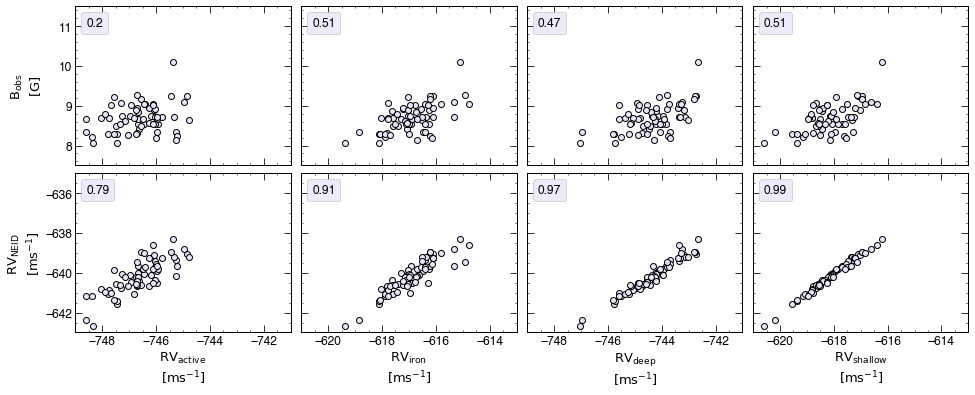

In [26]:
x_list = [wise_gauss*1e3, fe_gauss*1e3, deep_gauss*1e3, shallow_gauss*1e3]
y_list = [wise_Bobs, wise_rv*1e3, fe_Bobs, fe_rv*1e3,
          deep_Bobs, deep_rv*1e3, shallow_Bobs, shallow_rv*1e3]
xlabel_list = [r'$\rm RV_{\rm active}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm iron}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm deep}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm RV_{\rm shallow}$' '\n' r'$\rm[m s^{-1}]$']
ylabel_list = [r'$\rm B_{\rm obs}$' '\n' r'$\rm[G]$',
               r'$\rm RV_{\rm NEID}$' '\n' r'$\rm[m s^{-1}]$']

# plot style
plot_style = os.path.join(PlotDir.MPL, 'correlation.mplstyle')
plt.style.use(plot_style)

# calculate correlation coefficient
corr_one = stats.spearmanr(x_list[0], y_list[0])
corr_two = stats.spearmanr(x_list[1], y_list[2])
corr_three = stats.spearmanr(x_list[0], y_list[1])
corr_four = stats.spearmanr(x_list[1], y_list[3])

corr_five = stats.spearmanr(x_list[2], y_list[4])
corr_six = stats.spearmanr(x_list[3], y_list[6])
corr_seven = stats.spearmanr(x_list[2], y_list[5])
corr_eight = stats.spearmanr(x_list[3], y_list[7])

# setup the plot
fig, axs = plt.subplots(2, 4, sharey='row', sharex='col', figsize=[16, 6], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
axs[0, 0].set(ylabel=ylabel_list[0])
axs[1, 0].set(xlabel=xlabel_list[0], ylabel=ylabel_list[1])
axs[1, 1].set(xlabel=xlabel_list[1])
axs[1, 2].set(xlabel=xlabel_list[2])
axs[1, 3].set(xlabel=xlabel_list[3])

# plot data
color = 'lavender'
axs[0, 0].scatter(x_list[0], y_list[0], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_one[0], 2)))
axs[0, 1].scatter(x_list[1], y_list[2], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_two[0], 2)))
axs[1, 0].scatter(x_list[0], y_list[1], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_three[0], 2)))
axs[1, 1].scatter(x_list[1], y_list[3], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_four[0], 2)))

axs[0, 2].scatter(x_list[2], y_list[4], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_five[0], 2)))
axs[0, 3].scatter(x_list[3], y_list[6], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_six[0], 2)))
axs[1, 2].scatter(x_list[2], y_list[5], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_seven[0], 2)))
axs[1, 3].scatter(x_list[3], y_list[7], color=color, edgecolors='k', linewidths=1.0, label= str(np.around(corr_eight[0], 2)))

for i in range(0, 2):
    for j in range(0, 4):
        leg = axs[i, j].legend(handlelength=0, handletextpad=0, loc='upper left')
        for item in leg.legendHandles:
            item.set_visible(False)

# set axes tick marks and labels
# y labels
axs[0, 0].set(ylim=(7.5, 11.5), yticks=np.arange(8, 11.2, step=1))
axs[0, 1].set(ylim=(7.5, 11.5), yticks=np.arange(8, 11.2, step=1))

axs[1, 0].set(ylim=(-643, -635), yticks=np.arange(-642, -635.2, step=2))
axs[1, 1].set(ylim=(-643, -635), yticks=np.arange(-642, -635.2, step=2))

# x labels
axs[0, 0].set(xlim=(-749, -741), xticks=np.arange(-748, -741.2, step=2))
axs[1, 0].set(xlim=(-749, -741), xticks=np.arange(-748, -741.2, step=2))

axs[0, 1].set(xlim=(-621, -613), xticks=np.arange(-620, -613.2, step=2))
axs[1, 1].set(xlim=(-621, -613), xticks=np.arange(-620, -613.2, step=2))

axs[0, 2].set(xlim=(-749, -741), xticks=np.arange(-748, -741.2, step=2))
axs[1, 2].set(xlim=(-749, -741), xticks=np.arange(-748, -741.2, step=2))

axs[0, 3].set(xlim=(-621, -613), xticks=np.arange(-620, -613.2, step=2))
axs[1, 3].set(xlim=(-621, -613), xticks=np.arange(-620, -613.2, step=2))

# align y axis labels
fig.align_ylabels(axs)


# Figure 8: Comparison of strong CCF metrics (strong_ccf_metrics_2.png)

In [39]:

# relevant csv files
ccf_csv = os.path.join(CsvDir.CCFS, 'ccfs.csv')

# read in CCF csv file
dates, jd_dates, ccf_list, rv_sun, rv_model, rv_error, gaussian, rv_gauss, skew, int_area, Bobs, v_conv = utils.read_ccf_csv(ccf_csv)
ccf_inds = np.isin(jd_dates, good_days)
Bobs = Bobs[ccf_inds]
gaussian = gaussian[ccf_inds]
int_area = int_area[ccf_inds]
jd_dates = jd_dates[ccf_inds]
rv_sun = rv_sun[ccf_inds]
rv_model = rv_model[ccf_inds]
rv_error = rv_error[ccf_inds]
rv_gauss = rv_gauss[ccf_inds]
skew = skew[ccf_inds]
v_conv = v_conv[ccf_inds]

# get other gaussian parameters
FWHM = [g.fwhm for g in gaussian]
amplitude = [g.amplitude.value for g in gaussian]
sigma = [g.stddev.value for g in gaussian]

# csv file
spot_csv = os.path.join(CsvDir.ACTIVE, 'high_activity_days.csv')

# read it
spots = pd.read_csv(spot_csv)
spot_days = spots.date_jd.values
spot_days = [int(d) for d in spot_days]
jd_dates = [int(d) for d in jd_dates]

deep_spot_days = np.isin(deep_jd, spot_days)
shallow_spot_days = np.isin(shallow_jd, spot_days)
spot_days = np.isin(jd_dates, spot_days)


Text(0.925, 0.925, '-0.608\n-0.3\n-0.568')

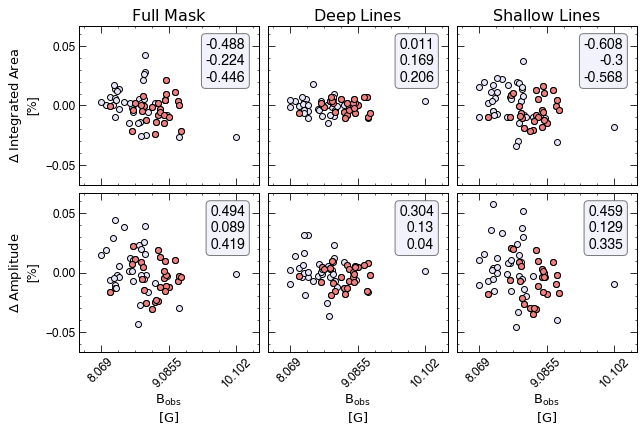

In [40]:
# setup plot
fig, axs = plt.subplots(2, 3, sharex='all', figsize=[10, 6], gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
ax1, ax2, ax3, ax4, ax5, ax6 = axs[1, 0], axs[0, 0], axs[1, 1], axs[0, 1], axs[1, 2], axs[0, 2]

x = np.array(Bobs)


# set y ticks
area_min = -0.05
area_max = 0.05
amp_min = -0.05
amp_max = 0.05

r = amp_max - amp_min
ax1.set(ylim=(amp_min - r/6, amp_max + r/6), yticks=np.arange(amp_min, amp_max + r/6, step=r/2))
ax3.set(ylim=(amp_min - r/6, amp_max + r/6), yticks=np.arange(amp_min, amp_max + r/6, step=r/2))
ax5.set(ylim=(amp_min - r/6, amp_max + r/6), yticks=np.arange(amp_min, amp_max + r/6, step=r/2))
ax3.set_yticklabels([])
ax5.set_yticklabels([])

r = area_max - area_min
ax2.set(ylim=(area_min - r/6, area_max + r/6), yticks=np.arange(area_min, area_max + r/6, step=r/2))
ax4.set(ylim=(area_min - r/6, area_max + r/6), yticks=np.arange(area_min, area_max + r/6, step=r/2))
ax6.set(ylim=(area_min - r/6, area_max + r/6), yticks=np.arange(area_min, area_max + r/6, step=r/2))
ax4.set_yticklabels([])
ax6.set_yticklabels([])

# set x ticks
r = np.max(x) - np.min(x)
ax1.set(xlim=(np.nanmin(x) - r/6, np.nanmax(x) + r/6), xticks=[np.round(a, 4) for a in np.arange(np.min(x), np.max(x) + r/6, step=r/2)])
ax3.set(xlim=(np.nanmin(x) - r/6, np.nanmax(x) + r/6), xticks=[np.round(a, 4) for a in np.arange(np.min(x), np.max(x) + r/6, step=r/2)])
ax5.set(xlim=(np.nanmin(x) - r/6, np.nanmax(x) + r/6), xticks=[np.round(a, 4) for a in np.arange(np.min(x), np.max(x) + r/6, step=r/2)])

ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)
ax5.set_xticklabels(ax5.get_xticks(), rotation = 45)

# set y-axis labels
ax1.set(ylabel=r'$\rm \Delta \; Amplitude$' '\n' r'$\rm$[%]')
ax2.set(ylabel=r'$\rm \Delta \; Integrated \; Area$' '\n' r'$\rm$[%]')

# set x-axis labels
ax1.set(xlabel=r'$\rm B_{\rm obs}$' '\n' r'$\rm[G]$')
ax3.set(xlabel=r'$\rm B_{\rm obs}$' '\n' r'$\rm[G]$')
ax5.set(xlabel=r'$\rm B_{\rm obs}$' '\n' r'$\rm[G]$')

# set titles
ax2.set_title(r'$\rm Full \; Mask$')
ax4.set_title(r'$\rm Deep \; Lines$')
ax6.set_title(r'$\rm Shallow \; Lines$')

# FULL MASK
x = np.array(Bobs)
x_plot = np.array(Bobs)[1:]
spot_days_plot = spot_days[1:]
# amplitude
y = np.array(amplitude)
s = pd.Series(amplitude)
y_plot = s.pct_change()[1:] * 100
ax1.scatter(x_plot, y_plot, color='lavender', edgecolor='black', linewidth=1.0)
ax1.scatter(x_plot[spot_days_plot], y_plot[spot_days_plot], color='lightcoral', edgecolor='black', linewidth=1.0)

corr = stats.spearmanr(x, y)
spot_corr = stats.spearmanr(x[spot_days], y[spot_days])
no_spot = stats.spearmanr(x[~spot_days], y[~spot_days])
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax1.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
       transform=ax1.transAxes, fontsize=14, color='k', alpha=1.0,
ha='right', va='top', fontweight='bold', bbox=props)

# area
y = int_area
s = pd.Series(int_area)
y_plot = s.pct_change()[1:] * 100
ax2.scatter(x_plot, y_plot, color='lavender', edgecolor='black', linewidth=1.0)
ax2.scatter(x_plot[spot_days_plot], y_plot[spot_days_plot], color='lightcoral', edgecolor='black', linewidth=1.0)

corr = stats.spearmanr(x, y)
spot_corr = stats.spearmanr(x[spot_days], y[spot_days])
no_spot = stats.spearmanr(x[~spot_days], y[~spot_days])
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax2.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
       transform=ax2.transAxes, fontsize=14, color='k', alpha=1.0, ha='right', va='top', fontweight='bold', bbox=props)

# DEEP LINES
x = np.array(deep_Bobs)
x_plot = np.array(deep_Bobs)[1:]
spot_days_plot = deep_spot_days[1:]
# amplitude
y = np.array(deep_amplitude)
s = pd.Series(deep_amplitude)
y_plot = s.pct_change()[1:] * 100
ax3.scatter(x_plot, y_plot, color='lavender', edgecolor='black', linewidth=1.0)
ax3.scatter(x_plot[spot_days_plot], y_plot[spot_days_plot], color='lightcoral', edgecolor='black', linewidth=1.0)

corr = stats.spearmanr(x, y)
spot_corr = stats.spearmanr(x[deep_spot_days], y[deep_spot_days])
no_spot = stats.spearmanr(x[~deep_spot_days], y[~deep_spot_days])
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax3.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
       transform=ax3.transAxes, fontsize=14, color='k', alpha=1.0,
ha='right', va='top', fontweight='bold', bbox=props)

# area
y = deep_area
s = pd.Series(deep_area)
y_plot = s.pct_change()[1:] * 100
ax4.scatter(x_plot, y_plot, color='lavender', edgecolor='black', linewidth=1.0)
ax4.scatter(x_plot[spot_days_plot], y_plot[spot_days_plot], color='lightcoral', edgecolor='black', linewidth=1.0)

corr = stats.spearmanr(x, y)
spot_corr = stats.spearmanr(x[deep_spot_days], y[deep_spot_days])
no_spot = stats.spearmanr(x[~deep_spot_days], y[~deep_spot_days])
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax4.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
       transform=ax4.transAxes, fontsize=14, color='k', alpha=1.0,
ha='right', va='top', fontweight='bold', bbox=props)

# SHALLOW LINES
x = np.array(shallow_Bobs)
x_plot = np.array(shallow_Bobs)[1:]
spot_days_plot = shallow_spot_days[1:]
# amplitude
y = np.array(shallow_amplitude)
s = pd.Series(shallow_amplitude)
y_plot = s.pct_change()[1:] * 100
ax5.scatter(x_plot, y_plot, color='lavender', edgecolor='black', linewidth=1.0)
ax5.scatter(x_plot[spot_days_plot], y_plot[spot_days_plot], color='lightcoral', edgecolor='black', linewidth=1.0)

corr = stats.spearmanr(x, y)
spot_corr = stats.spearmanr(x[shallow_spot_days], y[shallow_spot_days])
no_spot = stats.spearmanr(x[~shallow_spot_days], y[~shallow_spot_days])
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax5.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
       transform=ax5.transAxes, fontsize=14, color='k', alpha=1.0,
ha='right', va='top', fontweight='bold', bbox=props)

# area
y = shallow_area
s = pd.Series(shallow_area)
y_plot = s.pct_change()[1:] * 100
ax6.scatter(x_plot, y_plot, color='lavender', edgecolor='black', linewidth=1.0)
ax6.scatter(x_plot[spot_days_plot], y_plot[spot_days_plot], color='lightcoral', edgecolor='black', linewidth=1.0)

corr = stats.spearmanr(x, y)
spot_corr = stats.spearmanr(x[shallow_spot_days], y[shallow_spot_days])
no_spot = stats.spearmanr(x[~shallow_spot_days], y[~shallow_spot_days])
props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
ax6.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
       transform=ax6.transAxes, fontsize=14, color='k', alpha=1.0,
ha='right', va='top', fontweight='bold', bbox=props)


# plt.savefig('test.png')


# Figure 9: Corner Plot (corner_ccfs.png)

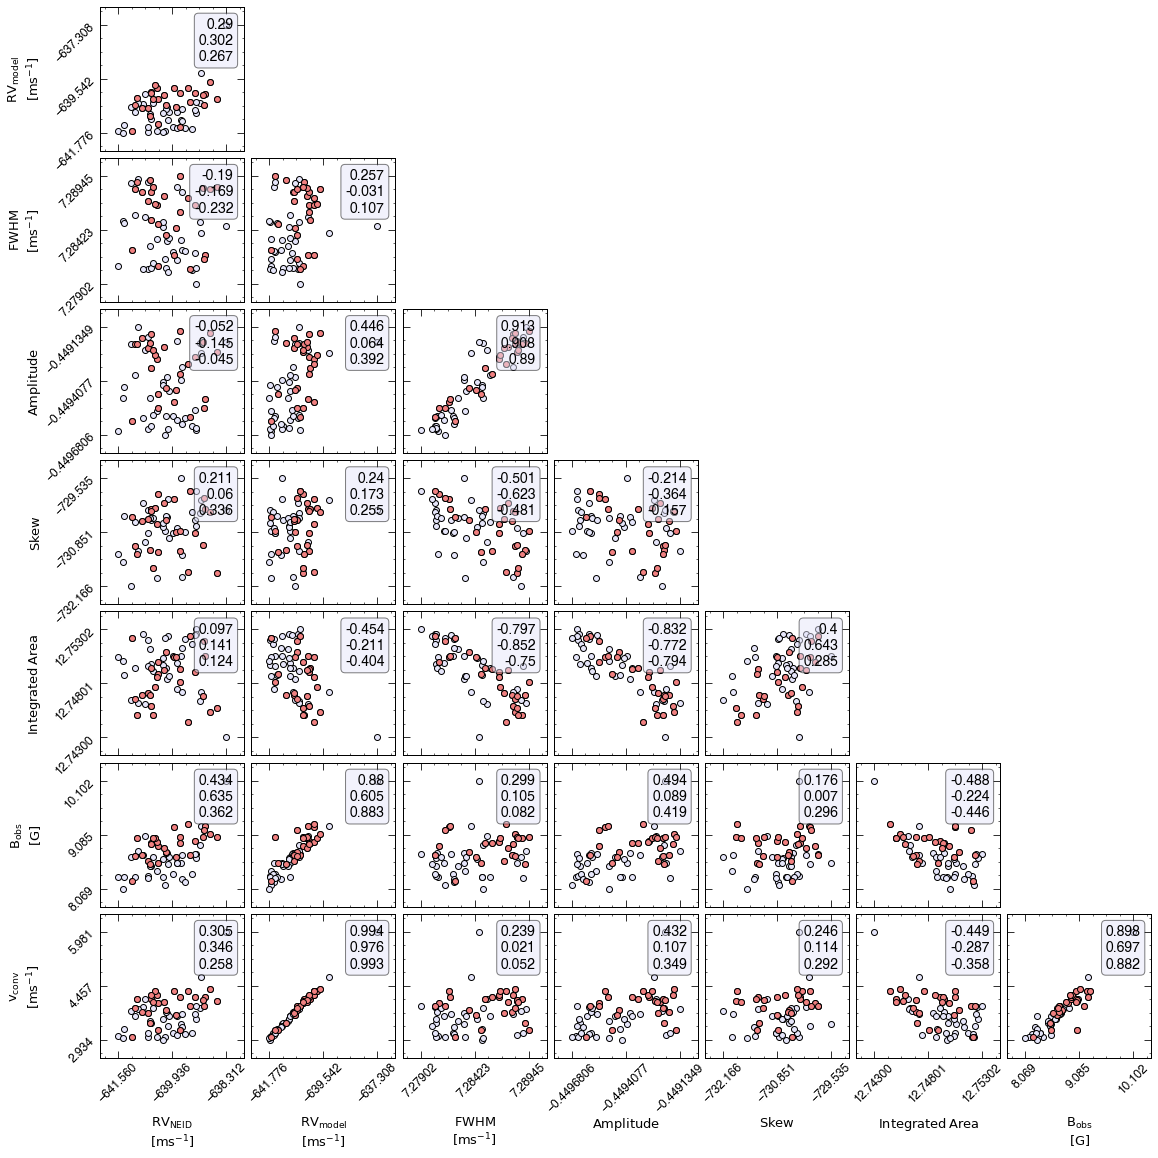

In [42]:

# for all days
data_list = [rv_sun, rv_model, FWHM, amplitude, skew, int_area, Bobs, v_conv]
labels = [r'$\rm RV_{\rm NEID}$' '\n' r'$\rm[m s^{-1}]$', r'$\rm RV_{\rm model}$' '\n' r'$\rm[m s^{-1}]$',
               r'$\rm FWHM$' '\n' r'$\rm[m s^{-1}]$', r'$\rm Amplitude$', r'$\rm Skew$', r'$\rm Integrated\/\rm Area$',
          r'$\rm B_{\rm obs}$' '\n' r'$\rm[G]$', r'$\rm v_{\rm conv}$' '\n' r'$\rm[m s^{-1}]$']

data = np.zeros((len(data_list[0]), len(data_list)))
for i, d in enumerate(data_list):
    data[:, i] = d

hist2d_kwargs={'quiet': True, 'plot_datapoints': True, 'plot_density': False, 'plot_contours': False, 'no_fill_contours': True}
corn = corner.corner(data, labels=labels, labelpad=0.1, **hist2d_kwargs)
# kwargs = {'marker': 'o', 'ms': 5, 'mfc': 'lavender', 'mec': 'k', 'mew': 0.5}
# corner.overplot_points(corn, xs=data, **kwargs)

# remove the 1D histograms
axes = np.array(corn.axes).reshape((len(data_list), len(data_list)))
for a in axes[np.triu_indices(len(data_list))]:
    a.remove()

for a in axes[np.tril_indices(len(data_list))]:
    line = a.lines
    if line:
        # plot stuff
        a.scatter(line[0].get_xdata(), line[0].get_ydata(), color='lavender', edgecolor='black', linewidth=1.0)
        a.scatter(line[0].get_xdata()[spot_days], line[0].get_ydata()[spot_days], color='lightcoral', edgecolor='black', linewidth=1.0)

        # set text box with correlation
        corr = stats.spearmanr(line[0].get_xdata(), line[0].get_ydata())
        spot_corr = stats.spearmanr(line[0].get_xdata()[spot_days], line[0].get_ydata()[spot_days])
        no_spot = stats.spearmanr(line[0].get_xdata()[~spot_days], line[0].get_ydata()[~spot_days])
        props = dict(boxstyle='round', facecolor='lavender', alpha=0.5)
        a.text(0.925, 0.925, str(np.round(corr[0], 3)) + '\n' + str(np.round(spot_corr[0], 3)) + '\n' + str(np.round(no_spot[0], 3)),
               transform=a.transAxes, fontsize=14, color='k', alpha=1.0,
        ha='right', va='top', fontweight='bold', bbox=props)

        # set axes grid tick marks
        r = np.max(line[0].get_xdata()) - np.min(line[0].get_xdata())
        a.set(xlim=(np.min(line[0].get_xdata()) - r/6, np.max(line[0].get_xdata()) + r/6), xticks=np.arange(np.min(line[0].get_xdata()), np.max(line[0].get_xdata()) + r/6, step=r/2))
        r = np.max(line[0].get_ydata()) - np.min(line[0].get_ydata())
        a.set(ylim=(np.min(line[0].get_ydata()) - r/6, np.max(line[0].get_ydata()) + r/6), yticks=np.arange(np.min(line[0].get_ydata()), np.max(line[0].get_ydata()) + r/6, step=r/2))

# corn.suptitle(title, fontsize=24, y=0.9, x=0.5, fontweight='bold')
# save_fig = os.path.join(ImgDir.CCF_IMG, 'metrics', 'corner_' + fig_name)
# corn.savefig(save_fig, pad_inches=0.5)


# Planetary Transits: Figures 10 and 11

## Data

In [3]:
import pandas as pd

# mercury 2016
transit_file = '2016_2min.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.MERCURY, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot_2016 = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_2016 = component_df.rv_model.values
f_spot = component_df.f_spot.values
Bobs_2016 = component_df.Bobs.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
print(date_jd[-1])
dates_2016 = date_jd - date_jd[0]
dates_2016 *= 86400/3600

# read in model
# mercury 2016
transit_file = 'mercury_2016_model_2min.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.MERCURY, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_2016_model = component_df.rv_model.values[:241]
f_spot = component_df.f_spot.values[:241]
Bobs_model = component_df.Bobs.values[:241]

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values[:241]
xlabel_2016 = 'Hours'
dates_2016_model = date_jd - date_jd[0]
dates_2016_model *= 86400/3600

# mercury 2019
transit_file = '2019_mercury_transit.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.MERCURY, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_2019 = component_df.rv_model.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
dates_2019 = date_jd - date_jd[0]
dates_2019 *= 86400/3600

# venus
transit_file = 'venus_2012_transit.csv'

# csv file with rv components
csv_file = os.path.join(CsvDir.VENUS, transit_file)
component_df = pd.read_csv(csv_file)
# get velocities lists
v_phot = component_df.v_phot.values
v_conv = component_df.v_conv.values
rv_venus = component_df.rv_model.values

# get dates list
dates = component_df.date_obs.values
date_jd = component_df.date_jd.values
dates_venus = date_jd - date_jd[0]
dates_venus *= 86400/3600

2457518.29


# Figure 10: Comparison of recovered transits (recovered.png)

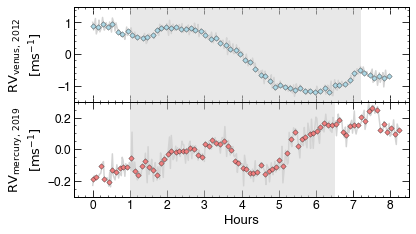

In [9]:
# plot recovered transits for comparison
fig, axs = plt.subplots(2, sharex='all', figsize=[6, 3.5],  gridspec_kw={'hspace': 0})

# plot venus
x_plot = dates_venus[:-42]
y_plot = rv_venus[:-42]-np.median(rv_venus[:-42])
x_bin = [dates_venus[i] for i in np.arange(0, len(dates_venus[:-42]), 4)]
y_bin = [np.average(y_plot[i:i+4]) for i in np.arange(0, len(dates_venus[:-42]), 4)]
axs[0].plot(x_plot, y_plot, color='lightgrey', zorder=1)
axs[0].scatter(x_bin, y_bin, color='lightblue', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)
axs[0].axvspan(1, 7.2, facecolor='lightgrey', alpha=0.5)

# plot mercury
x_plot = dates_2019[:-5]
y_plot = rv_2019[:-5] - np.median(rv_2019[:-5])
x_bin = [dates_2019[i] for i in np.arange(0, len(dates_2019[:-5]), 3)]
y_bin = [np.average(y_plot[i:i+3]) for i in np.arange(0, len(dates_2019[:-5]), 3)]
axs[1].plot(x_plot, y_plot, color='lightgrey', zorder=1)
axs[1].scatter(x_bin, y_bin, color='lightcoral', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)
axs[1].axvspan(1, 6.5, facecolor='lightgrey', alpha=0.5)

# labels and axes limits
axs[0].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[1].set(ylim=(-0.3, 0.3), yticks=np.arange(-0.2, .22, step=.2))
axs[0].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlabel='Hours')
axs[0].set(ylabel=r'$\rm RV_{venus, \, 2012}$' '\n' r'$\rm[m s^{-1}]$')
axs[1].set(ylabel=r'$\rm RV_{mercury, \, 2019}$' '\n' r'$\rm[m s^{-1}]$')
fig.align_ylabels(axs)

# Figure 11: Comparison of 2016 mercury transit and model

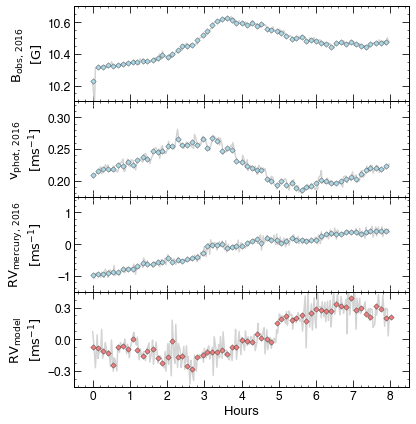

In [10]:
# plot recovered transits for comparison
fig, axs = plt.subplots(4, sharex='all', figsize=[6, 7],  gridspec_kw={'hspace': 0})

# plot mercury 2016 unsigned flux
x_plot = dates_2016
y_plot = Bobs_2016
x_bin = [dates_2016[i] for i in np.arange(0, len(dates_2016), 4)]
y_bin = [np.average(y_plot[i:i+4]) for i in np.arange(0, len(dates_2016), 4)]
axs[0].plot(x_plot, y_plot, color='lightgrey', zorder=1)
axs[0].scatter(x_bin, y_bin, color='lightblue', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)

# plot mercury 2016 photometric velocity
x_plot = dates_2016
y_plot = v_phot_2016
x_bin = [dates_2016[i] for i in np.arange(0, len(dates_2016), 4)]
y_bin = [np.average(y_plot[i:i+4]) for i in np.arange(0, len(dates_2016), 4)]
axs[1].plot(x_plot, y_plot, color='lightgrey', zorder=1)
axs[1].scatter(x_bin, y_bin, color='lightblue', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)

# plot mercury 2016
x_plot = dates_2016
y_plot = rv_2016-np.median(rv_2016)
x_bin = [dates_2016[i] for i in np.arange(0, len(dates_2016), 4)]
y_bin = [np.average(y_plot[i:i+4]) for i in np.arange(0, len(dates_2016), 4)]
axs[2].plot(x_plot, y_plot, color='lightgrey', zorder=1)
axs[2].scatter(x_bin, y_bin, color='lightblue', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)
# axs[0].axvspan(1, 7.2, facecolor='lightgrey', alpha=0.5)

# plot mercury 2016 model
x_plot = dates_2016_model
y_plot = rv_2016_model - np.median(rv_2016_model)
x_bin = [dates_2016_model[i] for i in np.arange(0, len(dates_2016_model), 4)]
y_bin = [np.average(y_plot[i:i+4]) for i in np.arange(0, len(dates_2016_model), 4)]
axs[3].plot(x_plot, y_plot, color='lightgrey', zorder=1)
axs[3].scatter(x_bin, y_bin, color='lightcoral', s=15, marker='D', zorder=2, edgecolor='k', linewidth=0.3)
# axs[1].axvspan(1, 6.5, facecolor='lightgrey', alpha=0.5)

# labels and axes limits
axs[0].set(ylim=(10.1, 10.7), yticks=np.arange(10.2, 10.62, step=0.2))
axs[1].set(ylim=(0.175, 0.325), yticks=np.arange(0.20, .302, step=.05))
axs[2].set(ylim=(-1.5, 1.5), yticks=np.arange(-1, 1.2, step=1))
axs[3].set(ylim=(-0.45, 0.45), yticks=np.arange(-0.3, .32, step=.3))
# axs[3].set(ylim=(-0.375, 0.375), yticks=np.arange(-0.25, .252, step=.25))

axs[0].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[1].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[2].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[3].set(xlim=(-0.5, 8.5), xticks=np.arange(0, 8.2, step=1))
axs[3].set(xlabel='Hours')
axs[0].set(ylabel=r'$\rm B_{obs, \, 2016}$' '\n' r'$\rm[G]$')
axs[1].set(ylabel=r'$\rm v_{phot, \, 2016}$' '\n' r'$\rm[m s^{-1}]$')
axs[2].set(ylabel=r'$\rm RV_{mercury, \, 2016}$' '\n' r'$\rm[m s^{-1}]$')
axs[3].set(ylabel=r'$\rm RV_{model}$' '\n' r'$\rm[m s^{-1}]$')
fig.align_ylabels(axs)